In [ ]:
import pandas as pd


'''Create 30 user-movie matrix and their correspondng ratings'''
!head ./data/goodreads_interactions.csv

In [ ]:
csv_book_mapping = {}

with open('./data/book_id_map.csv', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        csv_id, book_id = line.strip().split(',')
        csv_book_mapping[csv_id] = book_id

books_titles = pd.read_json('./data/books_title.json')
books_titles['book_id'] = books_titles['book_id'].astype(str)

In [ ]:
users = ['0', '4297', '4574', '2518', '1440', '1830', '2063', '3075', '2816', '3732']

In [ ]:
user = []
with open('./data/goodreads_interactions.csv') as f:
    books = []
    while len(user) < 40:
        line = f.readline()
        if not line:
            break

        user_id, csv_id, _, rating, _ = line.strip().split(',')

        if user_id == '3732' and rating >= '4':
            book_id = csv_book_mapping[csv_id]
            if book_id not in books:
                title = books_titles.loc[books_titles['book_id'] == book_id]['title'].iloc[0]
                user.append([user_id, book_id, rating, title])
                books.append(book_id)

In [ ]:
user_0 = pd.DataFrame(user, columns = ['user_id', 'book_id', 'rating', 'title'])
user_0.to_csv('./data/users/user_3732.csv', index = False)

## Evaluate Model

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

'''With hold some of the row entries for testing'''
from sklearn.model_selection import train_test_split

user = pd.read_csv('./data/users/user_0.csv')
user['book_id'] = user['book_id'].astype(str)

train, test = train_test_split(user, test_size = 0.3)
user_books = train

In [2]:
''' 
    Need to figure out users that are similar to us. We'll do this using loading book_id_map.csv
'''
csv_book_mapping = {}

with open('./data/book_id_map.csv', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        csv_id, book_id = line.strip().split(',')
        csv_book_mapping[csv_id] = book_id

book_set = set(user_books['book_id']) # Unique books that I like
overlap_users = {}

# Add users in overlap_users if they have read the same books as you
with open('./data/goodreads_interactions.csv') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.strip().split(',')

        book_id = csv_book_mapping.get(csv_id)
        if book_id in book_set:
            if user_id not in overlap_users:
                overlap_users[user_id] = 1
            else:
                overlap_users[user_id] += 1
            
# Total users who have read the same books as you
print ('Total users who\'ve read the same books as you: {}'.format(len(overlap_users)))


# Users who have read at least 20% of the books that you've read
filtered_overlap_users = set([k for k in overlap_users if overlap_users[k] > user_books.shape[0]/5]) # 1258 users
print ('Total users who\'ve read at least 20% of the books that you\'ve read: {}'.format(len(filtered_overlap_users)))

Total users who've read the same books as you: 346332
Total users who've read at least 20% of the books that you've read: 3754


In [3]:
# Create a list for futher processing
interactions_list = []
with open('./data/goodreads_interactions.csv') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.strip().split(',')

        if user_id in filtered_overlap_users:
            book_id = csv_book_mapping[csv_id]
            interactions_list.append([user_id, book_id, rating])

print ('Total books in filtered user list: {}\n'.format(len(interactions_list)))

'''
Build Collaborative Filtering Features i.e. user-book matrix containing ratings in each cell
'''

# Create a dataframe for the above list
interactions = pd.DataFrame(interactions_list, columns = ['user_id', 'book_id', 'rating'])

# Concatenate your book ratings to the ratings from everyone else
interactions = pd.concat([user_books[['user_id', 'book_id', 'rating']], interactions])
interactions['book_id'] = interactions['book_id'].astype(str)
interactions['user_id'] = interactions['user_id'].astype(str)
interactions['rating'] = pd.to_numeric(interactions['rating'])
# We want each user_id to correspond to a single row in a matrix. So we're assigning index to each of these user_ids 
interactions['user_index'] = interactions['user_id'].astype('category').cat.codes
# We do the same with book_id so that we can create a matrix user_index X book_index
interactions['book_index'] = interactions['book_id'].astype('category').cat.codes

print ('Number of unique users: {}\nNumber of unique books: {}'.format(len(interactions['user_index'].unique()), len(interactions['book_index'].unique())))

'''
    We'll create a sparse matrix to save memory
'''

matrix = (interactions['rating'], (interactions['user_index'], interactions['book_index']))
ratings_mat_coo = coo_matrix(matrix)
ratings_mat = ratings_mat_coo.tocsr()  # Convert to compressed sparse row format


interactions[interactions['user_id'] == '-1']
my_index = 0  # Corresponds to row 0 of the matrix i.e. your information


# Use Cosine Similarity to find user who are similar to us
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()

# Find indices of top n users who are more similar to us
indices = np.argpartition(similarity, -10)[-10:]


# Find their user_id
similar_users = interactions[interactions['user_index'].isin(indices)].copy()

# Remove all entries that corresponds to you
similar_users = similar_users[similar_users['user_id'] != '-1']

book_recs = similar_users.groupby('book_id').rating.agg(['count', 'mean'])

Total books in filtered user list: 7650512

Number of unique users: 3754
Number of unique books: 895192


In [4]:
books_title = pd.read_json('./data/books_title.json')
books_title['book_id'] = books_title['book_id'].astype(str)

In [5]:
books_recs = book_recs.merge(books_title, how = 'inner', on = 'book_id')


books_recs["adjusted_count"] = books_recs["count"] * (books_recs["count"] / books_recs['ratings'])


books_recs['score'] = books_recs['mean'] * books_recs['adjusted_count']
books_recs = books_recs[~books_recs['book_id'].isin(user_books['book_id'])] # take out books that you've already read

user_books['mod_title'] = user_books['title'].str.replace('[a-zA-Z0-9 ]', '', regex = True).str.lower()
user_books['mod_title'] = user_books['mod_title'].str.replace('\s+', ' ', regex = True)

book_recs = books_recs[~books_recs['mod_title'].isin(user_books['mod_title'])]
book_recs = book_recs[book_recs['count']>2]
book_recs = book_recs[book_recs['mean']>4]

top_recs = book_recs.sort_values('score', ascending = False)

def show_img(x):
    return '<img src="{}" width=50></img>'.format(x)

In [6]:
top_recs.style.format({'cover_image': show_img})

,book_id,count,mean,title,ratings,cover_image,mod_title,adjusted_count,score
1400,42432,5,4.200000,God Emperor of Dune (Dune Chronicles #4),46358,,god emperor of dune dune chronicles 4,0.000539,0.002265
881,234225,9,4.222222,Dune (Dune Chronicles #1),494553,,dune dune chronicles 1,0.000164,0.000692
76,1067,4,4.500000,1776,135293,,1776,0.000118,0.000532
532,17214,4,4.500000,Starship Troopers,139876,,starship troopers,0.000114,0.000515
636,18512,7,4.571429,"The Return of the King (The Lord of the Rings, #3)",473101,,the return of the king the lord of the rings 3,0.000104,0.000473
411,15241,7,4.571429,"The Two Towers (The Lord of the Rings, #2)",490005,,the two towers the lord of the rings 2,0.000100,0.000457
1740,662,5,4.600000,Atlas Shrugged,287835,,atlas shrugged,0.000087,0.000400
890,23772,6,4.166667,Green Eggs and Ham,465289,,green eggs and ham,0.000077,0.000322
1892,7669,3,4.666667,Timeline,150786,,timeline,0.000060,0.000279
1197,33,5,4.400000,"The Lord of the Rings (The Lord of the Rings, #1-3)",396933,,the lord of the rings the lord of the rings 13,0.000063,0.000277


In [41]:
y_pred = top_recs['book_id'].to_numpy().astype(int)
y = test['book_id'].to_numpy().astype(int)


In [48]:
y_pred_cf = y_pred[:len(y)]

<AxesSubplot:>

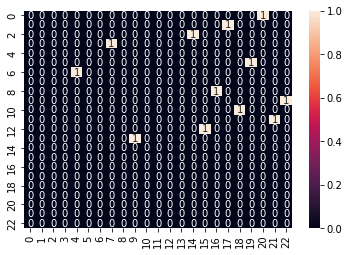

In [50]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y, y_pred_cf)

import seaborn as sns
sns.heatmap(cf, annot= True)


In [67]:
def precision(y, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] in y:
            TP += 1
            #print (y_pred[i])
        else:
            FP += 1
    precision = TP/(TP+FP)
    return precision

In [68]:
precision(y, y_pred_cf)

0.08333333333333333